# IMPORTS

In [2]:
#importing relevant libraries

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    #for fitting an exponential
import functools as fnt
from textwrap import wrap

# CONSTANTS

In [3]:
#relevant constants
pc = 3.086e18                   #cm
pi = np.pi

#galaxy specific constants (taken from SS21_ch11)
r = 10*(10**3)*pc           #radius in cm
omega = 6.481*(10**(-18))   #angular velocity in s^-1
h = 0.5*(10**3)*pc          #height in cm
eta_T = 10**26              #Diffusion coefficient in cm^2 s^-1
to = h*h/eta_T              #diffusion time in s
print('time stepping is normalised to to(s) = ', to)

time stepping is normalised to to(s) =  2.380849e+16


# DIFFERENTIAL EQUATIONS

In [4]:
def Br_diff(t, Br, Bp, r_ind, dz, alpha):                          #for both alpha-omega and alpha-square omega dynamo

    dBr_dt = np.array(-1*(0)*(-3*Bp[0] + 4*Bp[1] - Bp[2])/(2*dz) + (2*Br[0] - 5*Br[1] + 4*Br[2] - Br[3])/(dz**2))                           #for boundary
    dBr_dt = np.append(dBr_dt, -1*alpha[r_ind]*np.array(Bp[2:] - Bp[:-2])/(2*dz) + np.array(Br[:-2] + Br[2:] - 2*Br[1:-1])/(dz**2))         #for interior
    dBr_dt = np.append(dBr_dt, -1*alpha[r_ind]*(3*Bp[-1] - 4*Bp[-2] + Bp[-3])/(2*dz) + (2*Br[-1] - 5*Br[-2] + 4*Br[-3] - Br[-4])/(dz**2))   #for boundary
    return dBr_dt

def Bp_diff(t, Br, Bp, r_ind, dz, alpha, S, Ralpha, Romega, ao = True):     

    D = Ralpha*Romega
    if ao:          #for alpha-omega dynamo 
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2) )                                               #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))                         #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))                                   #for boundary
    else:           #for alpha-square omega dynamo
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (Ralpha**2)*alpha[r_ind]*(-3*Br[0] + 4*Br[1] - Br[2])/(2*dz) + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2))                         #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + (Ralpha**2)*alpha[r_ind]*np.array(Br[2:] - Br[:-2])/(2*dz) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))    #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (Ralpha**2)*alpha[r_ind]*(3*Br[-1] - 4*Br[-2] + Br[-3])/(2*dz) + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))          #for boundary
    
    return dBp_dt

# RUNGE KUTTA (4TH ORDER)

### For Dirichlet Boundary Conditions
These boundary conditions specify that the time evolution of the boundary values is fixed to some number.

### For Neumann Boundary Conditions
These boundary conditions specify that the spatial derivatives of the function values are some number at the boundary.

This Runge-Kutta code solves a general system of differential equations in two variables(since in our case we have Br and Bphi)

In [5]:
def rk4(F, G, X, Y, BX0, BXn, BY0, BYn, t, dt, dz, bc = 'dir'):
    #F is the function for the time evolution of X, in our case Br
    #G is the function for the time evolution of Y, in our case Bp
    #X is the array of X values
    #Y is the array of Y values
    #t is the current time
    #dt is the time step
    #dz is the spatial step
    #bc is the boundary condition type
    #BX0, BY0, BXn, BYn are the boundary values

    #We know the time evolution of the borders
    #So we only need to solve for the interior

    #let len(X) = len(Y) = n
    #Assigning the first boundary value
    if bc == 'dir':
        X_new = np.array([BX0])
        Y_new = np.array([BY0])
    elif bc == 'neu':
        X_new = np.array([4*X[1]/3 - X[2]/3 - 2*dz*BX0/3])
        Y_new = np.array([4*Y[1]/3 - Y[2]/3 - 2*dz*BY0/3])

    #Solving the runge kutta coefficients
    k1 = F(t, X, Y)                                     #len = n
    l1 = G(t, X, Y)                                     #len = n

    k2 = F(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n        
    l2 = G(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n

    k3 = F(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n
    l3 = G(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n

    k4 = F(t + dt, X + k3*dt, Y + l3*dt)                #len = n
    l4 = G(t + dt, X + k3*dt, Y + l3*dt)                #len = n

    #Assigning the interior values
    X_new = np.append(X_new, X[1:-1] + np.array(k1 + 2*k2 + 2*k3 + k4)[1:-1]*dt/6)
    Y_new = np.append(Y_new, Y[1:-1] + np.array(l1 + 2*l2 + 2*l3 + l4)[1:-1]*dt/6)

    #Assigning the last boundary value
    if bc == 'dir':
        X_new = np.append(X_new, BXn)        
        Y_new = np.append(Y_new, BYn)
    elif bc == 'neu':
        X_new = np.append(X_new, 4*X[-2]/3 - X[-3]/3 + 2*dz*BXn/3)
        Y_new = np.append(Y_new, 4*Y[-2]/3 - Y[-3]/3 + 2*dz*BYn/3)

    return X_new, Y_new

### Checking for diffusion equation

In [6]:
#defining the grid and timestepping

#grid parameters
z_res = 2*10**2                 #resolution
z0 = -1                         #lower z/h limit
zn = 1                          #upper z/h limit
dz = (zn-z0)/z_res              #step size
z = np.linspace(z0, zn, z_res)  #normalised to scale height h

#time parameters
steps = 2*10**4
dt = 0.000049
t0 = 0

print('dt/to =', dt, 'and dz =', dz)
print('The solution is stable when 2*dt/(dz**2) =', 2*dt/(dz**2), '< 1')

dt/to = 4.9e-05 and dz = 0.01
The solution is stable when 2*dt/(dz**2) = 0.9799999999999999 < 1


In [7]:
#constants and other known variables (0 for the diffusion equation)
alpha = np.zeros(z_res)
S = np.zeros(z_res)
Ralpha = 0
Romega = 0
r_ind = 0

#Initial seed fields
Br1 = np.cos(pi*z/2)
Bp1 = np.cos(pi*z/2)
Br2 = (np.cos(pi*z/2))**2 + (np.cos(3*pi*z/2))**2
Bp2 = (np.cos(pi*z/2))**2 + (np.cos(3*pi*z/2))**2
Br3 = np.sin(pi*z)       
Bp3 = np.sin(pi*z)

#Dirichlet boundary conditions
Br1_0 = 0
Br1_n = 0
Bp1_0 = 0
Bp1_n = 0

Br2_0 = 0
Br2_n = 0
Bp2_0 = 0
Bp2_n = 0

Br3_0 = 0
Br3_n = 0
Bp3_0 = 0
Bp3_n = 0

#Neumann boundary conditions
dBr1_0 = 0
dBr1_n = 0
dBp1_0 = 0
dBp1_n = 0

dBr2_0 = 0
dBr2_n = 0
dBp2_0 = 0
dBp2_n = 0

dBr3_0 = 0
dBr3_n = 0
dBp3_0 = 0
dBp3_n = 0

#Removing function dependence on known values by specifying them
Br_diff_eq = fnt.partial(Br_diff, r_ind = r_ind, dz = dz, alpha = alpha)
Bp_diff_eq = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, Ralpha = Ralpha, Romega = Romega)

#### Since the equations for Br and Bp are decoupled, we can solve them independently. The evolution of both Br and Bp will be same, and hence we can plot the evolution of Br only.

In [8]:
#initialising the solutions
Br1_sol1 = np.array([Br1])
Bp1_sol1 = np.array([Bp1])
Br1_sol2 = np.array([Br1])
Bp1_sol2 = np.array([Bp1])
Br2_sol1 = np.array([Br2])
Bp2_sol1 = np.array([Bp2])
Br2_sol2 = np.array([Br2])
Bp2_sol2 = np.array([Bp2])
Br3_sol1 = np.array([Br3])
Bp3_sol1 = np.array([Bp3])
Br3_sol2 = np.array([Br3])
Bp3_sol2 = np.array([Bp3])
t = np.array([t0])

for i in range(steps):

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br1_sol1[-1], Bp1_sol1[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br1_sol1 = np.append(Br1_sol1, [Br_temp], axis = 0)
    Bp1_sol1 = np.append(Bp1_sol1, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br1_sol2[-1], Bp1_sol2[-1], dBr1_0, dBr1_n, dBp1_0, dBp1_n, t[-1], dt, dz, bc = 'neu')
    Br1_sol2 = np.append(Br1_sol2, [Br_temp], axis = 0)
    Bp1_sol2 = np.append(Bp1_sol2, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br2_sol1[-1], Bp2_sol1[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br2_sol1 = np.append(Br2_sol1, [Br_temp], axis = 0)
    Bp2_sol1 = np.append(Bp2_sol1, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br2_sol2[-1], Bp2_sol2[-1], dBr2_0, dBr2_n, dBp2_0, dBp2_n, t[-1], dt, dz, bc = 'neu')
    Br2_sol2 = np.append(Br2_sol2, [Br_temp], axis = 0)
    Bp2_sol2 = np.append(Bp2_sol2, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br3_sol1[-1], Bp3_sol1[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br3_sol1 = np.append(Br3_sol1, [Br_temp], axis = 0)
    Bp3_sol1 = np.append(Bp3_sol1, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br3_sol2[-1], Bp3_sol2[-1], dBr3_0, dBr3_n, dBp3_0, dBp3_n, t[-1], dt, dz, bc = 'neu')
    Br3_sol2 = np.append(Br3_sol2, [Br_temp], axis = 0)
    Bp3_sol2 = np.append(Bp3_sol2, [Bp_temp], axis = 0)

    t = np.append(t, t[-1] + dt)

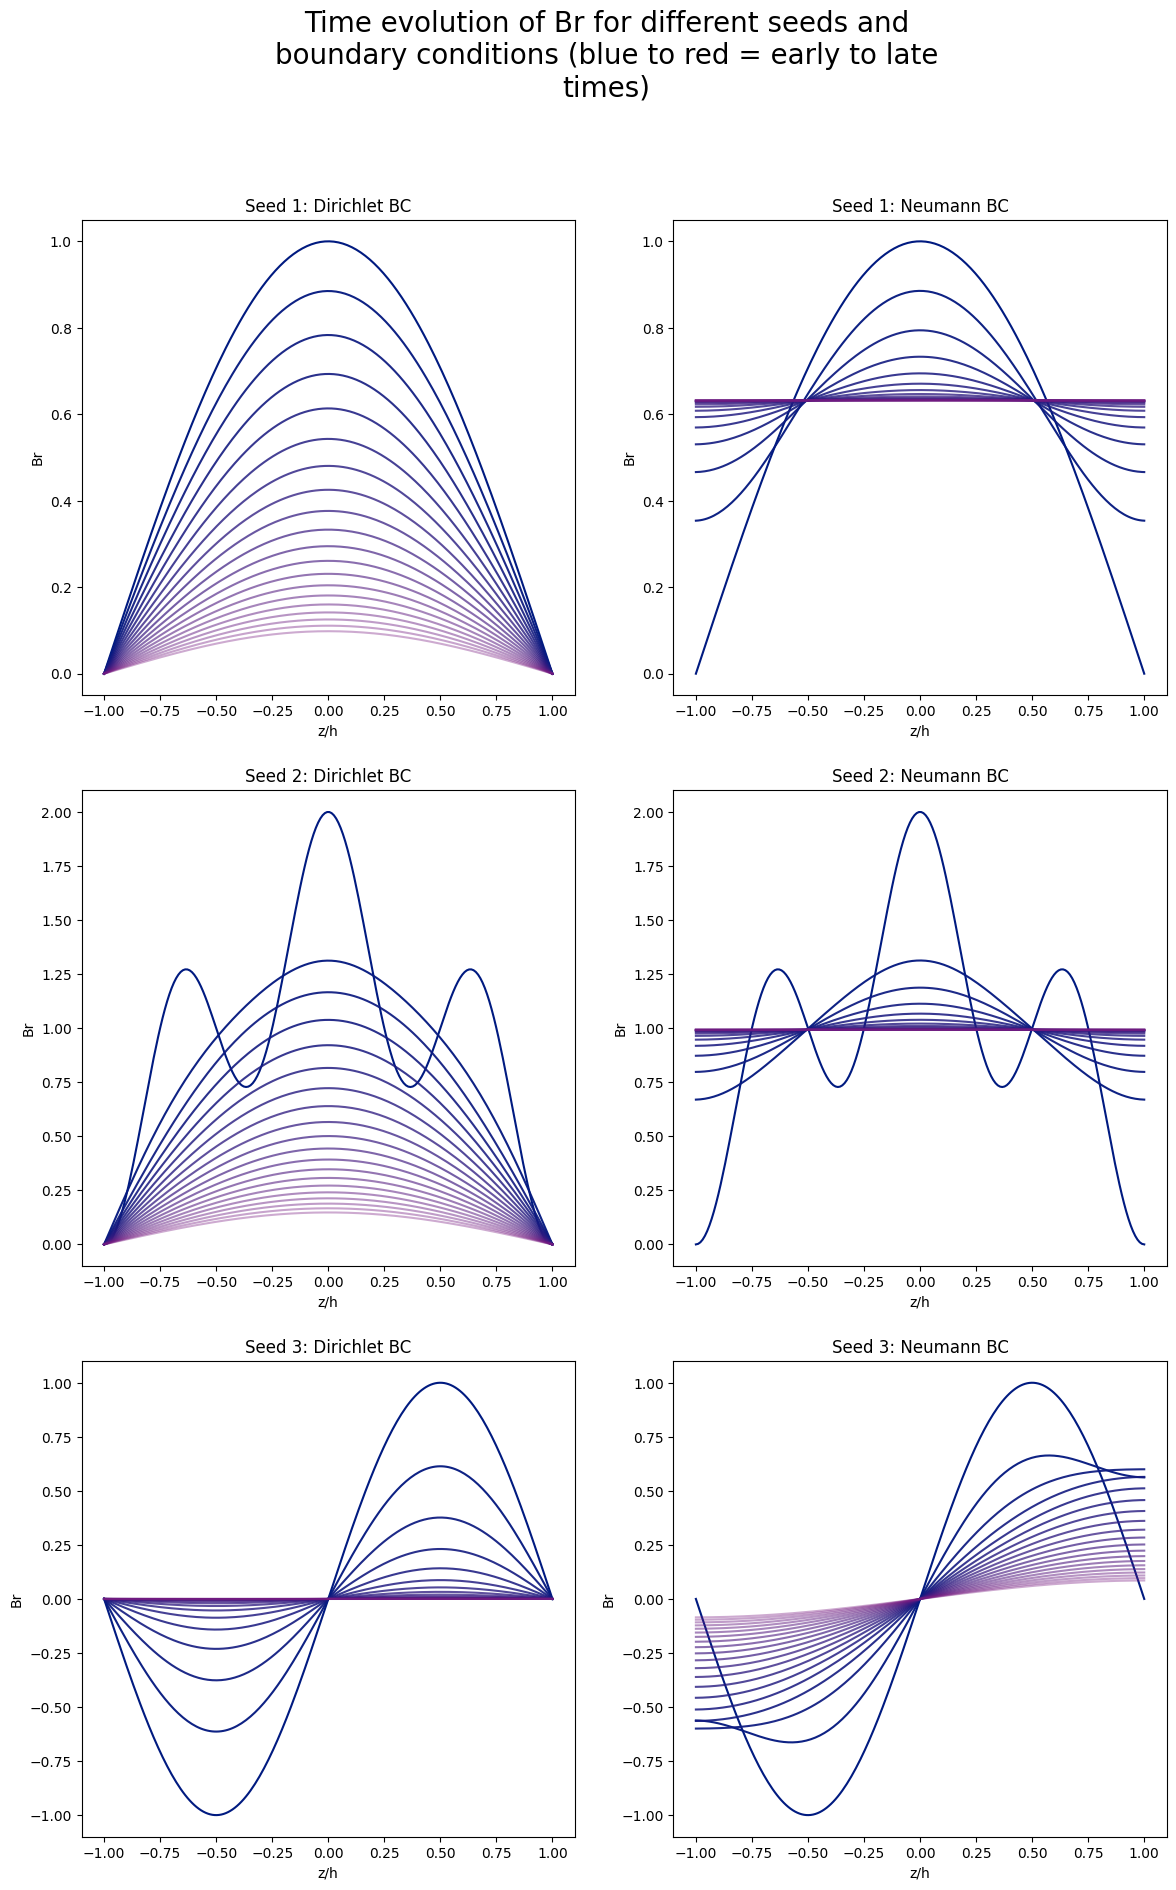

In [9]:
fig, axs = plt.subplots(3, 2, figsize = (14, 21))
i = 0
fig.suptitle("\n".join(wrap("Time evolution of Br for different seeds and boundary conditions (blue to red = early to late times)", 50)), size = 20)

while i < steps:
    axs[0, 0].plot(z, Br1_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[0, 0].set_title('Seed 1: Dirichlet BC')

    axs[0,1].plot(z, Br1_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[0, 1].set_title('Seed 1: Neumann BC')

    axs[1,0].plot(z, Br2_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[1, 0].set_title('Seed 2: Dirichlet BC')

    axs[1,1].plot(z, Br2_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[1, 1].set_title('Seed 2: Neumann BC')

    axs[2,0].plot(z, Br3_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[2, 0].set_title('Seed 3: Dirichlet BC')

    axs[2,1].plot(z, Br3_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[2, 1].set_title('Seed 3: Neumann BC')

    i += 1000

for ax in axs.flat:
    ax.set(xlabel='z/h', ylabel='Br')

#### We can see that the high frequency components of the seed field decay faster than the low frequency components, as the sharp peaks are smoothened earlier than the large scale features, like the sinusoidal component which persists for longer times(last red curve).

#### Also, we have explored the dipolar and quadrupolar symmetries as well. The first and second seed fields have dipolar symmetry, but the third seed field has quadrupolar symmetry.

# TIME EVOLUTION AND DECAY RATES

#### We fit the magnitude of B at z = 0 to an exponential, and find the decay rates

In [10]:
#defining the exponential fit function
def exp(t, A, b):
    return A * np.exp(b * t)

def fit_exp(data, t):
    #Fit exponential curve to the data
    popt, pcov = curve_fit(exp, t, data)

    return popt  # Return parameters A and b of the fit

The exponential fit for the time evolution of Br at z = 0 is:
For first seed field, with dirichlet BCs, A =  0.999968846927263 and b =  -2.492209647411751
For first seed field, with neumann BCs, A =  0.787605240101802 and b =  -0.3246979422850932
For second seed field, with dirichlet BCs, A =  1.5427186637013843 and b =  -2.5676052403381324
For second seed field, with neumann BCs, A =  1.209825162872548 and b =  -0.2942376847796378
For third seed field, with dirichlet BCs, A =  0.9999688474538798 and b =  -9.968217512721088
For third seed field, with neumann BCs, A =  0.7601300253607225 and b =  -3.162011411558619


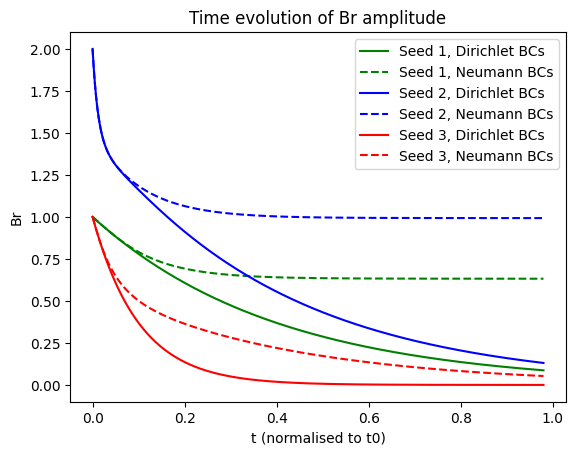

In [18]:
#Saving array of evolution of B at z = 0 for seed 1 and 2, and z = -1/2 for seed 3
Br1_sol1_z0 = Br1_sol1[:, z_res//2]
Br1_sol2_z0 = Br1_sol2[:, z_res//2]
Br2_sol1_z0 = Br2_sol1[:, z_res//2]
Br2_sol2_z0 = Br2_sol2[:, z_res//2]
Br3_sol1_z0 = -Br3_sol1[:, z_res//4]
Br3_sol2_z0 = -Br3_sol2[:, z_res//4]

#fitting to exponential Aexp(bt)
A11, B11 = fit_exp(Br1_sol1_z0, t)
A12, B12 = fit_exp(Br1_sol2_z0, t)
A21, B21 = fit_exp(Br2_sol1_z0, t)
A22, B22 = fit_exp(Br2_sol2_z0, t)
A31, B31 = fit_exp(Br3_sol1_z0, t)
A32, B32 = fit_exp(Br3_sol2_z0, t)

print("The exponential fit for the time evolution of Br at z = 0 is:")
print("For first seed field, with dirichlet BCs, A = ", A11 ,"and b = ", B11)
print("For first seed field, with neumann BCs, A = ", A12 ,"and b = ", B12)
print("For second seed field, with dirichlet BCs, A = ", A21 ,"and b = ", B21)
print("For second seed field, with neumann BCs, A = ", A22 ,"and b = ", B22)
print("For third seed field, with dirichlet BCs, A = ", A31 ,"and b = ", B31)
print("For third seed field, with neumann BCs, A = ", A32 ,"and b = ", B32)

#plotting the time evolution of magnitude
plt.plot(t, Br1_sol1_z0, label = 'Seed 1, Dirichlet BCs', color = 'g',  linestyle = '-')
plt.plot(t, Br1_sol2_z0, label = 'Seed 1, Neumann BCs', color = 'g', linestyle = '--')
plt.plot(t, Br2_sol1_z0, label = 'Seed 2, Dirichlet BCs', color = 'b', linestyle = '-')
plt.plot(t, Br2_sol2_z0, label = 'Seed 2, Neumann BCs', color = 'b', linestyle = '--')
plt.plot(t, Br3_sol1_z0, label = 'Seed 3, Dirichlet BCs', color = 'r', linestyle = '-')
plt.plot(t, Br3_sol2_z0, label = 'Seed 3, Neumann BCs', color = 'r', linestyle = '--')
plt.title('Time evolution of Br amplitude')
plt.xlabel('t (normalised to t0)')
plt.ylabel('Br')
plt.legend()
plt.show()
plt.close()


#### We can see the exponenial decay of the fields, and we can see that Dirichlet boundary conditions lead to a faster decay

#### We can quantitatively see that there is a faster decay for seed fields with more high frequency components. This is consistent with the fact that high frequency components are diffused earlier 


# PITCH ANGLE

#### As the evolution of the seed field for the first three seed fields is exactly the same for both Br and Bp, the pitch angle would be constant(=1) throughout. This can be seen in the following plots.

/tmp/ipykernel_41379/1981529244.py:2: RuntimeWarning: invalid value encountered in divide
  return 180*np.arctan(Bp/Br)/np.pi


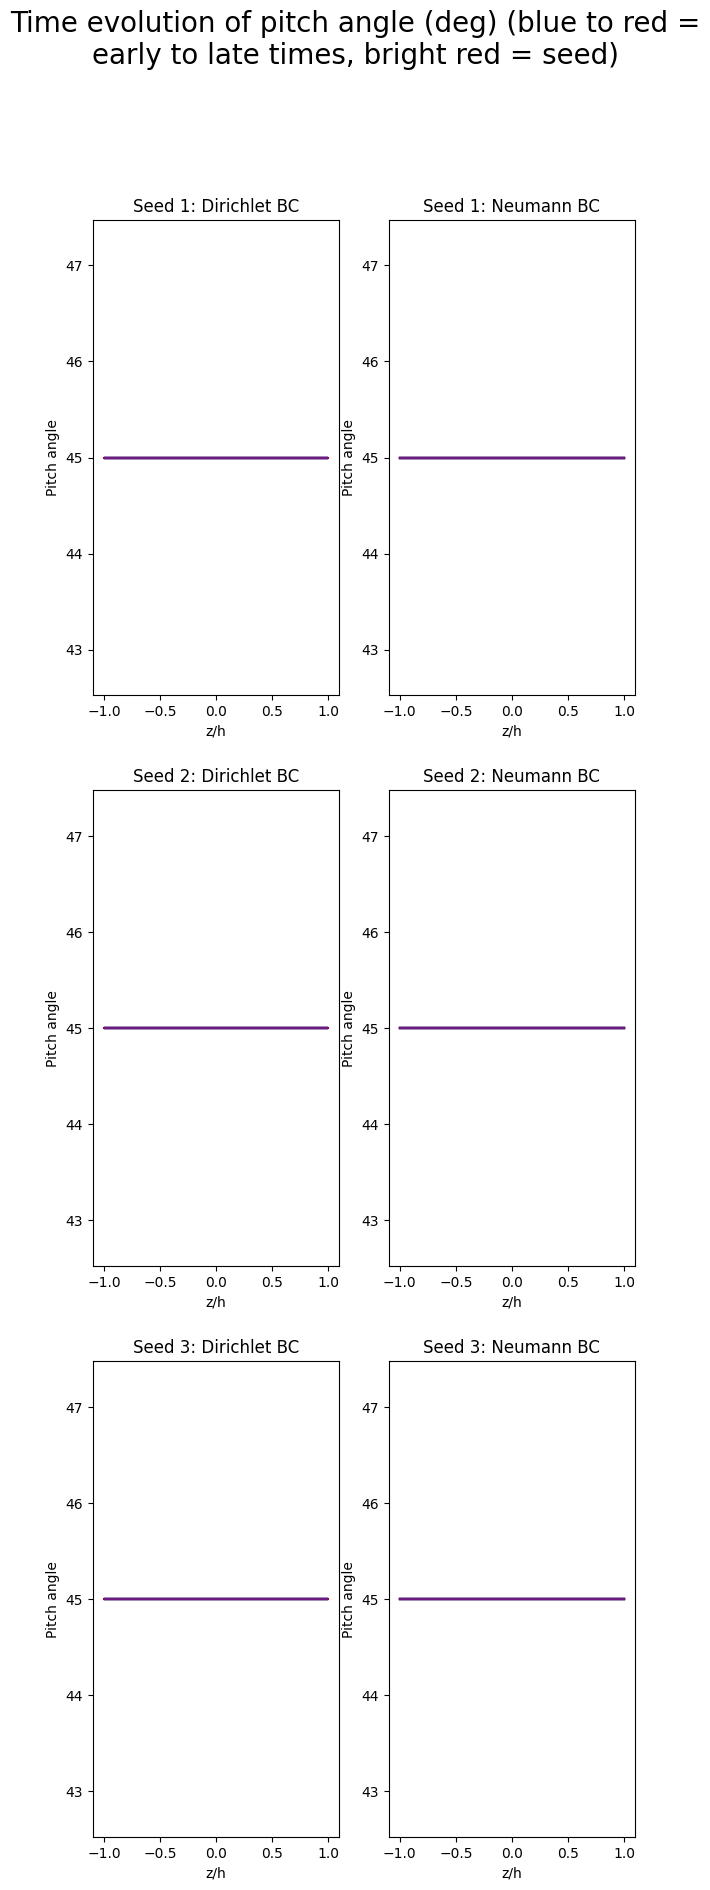

In [26]:
def pitch(Br, Bp):
    return 180*np.arctan(Bp/Br)/np.pi

i = 1000
fig6, axs6 = plt.subplots(3, 2, figsize = (7, 21))
fig6.suptitle("\n".join(wrap("Time evolution of pitch angle (deg) (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs6[0,0].plot(z, pitch(Br1_sol1[0], Bp1_sol1[0]), color = 'red')
axs6[0,0].set_title('Seed 1: Dirichlet BC')
axs6[0,0].set(xlabel='z/h', ylabel='Pitch angle')

axs6[1,0].plot(z, pitch(Br2_sol1[0], Bp2_sol1[0]), color = 'red')
axs6[1,0].set_title('Seed 2: Dirichlet BC')
axs6[1,0].set(xlabel='z/h', ylabel='Pitch angle')

axs6[2,0].plot(z, pitch(Br3_sol1[0], Bp3_sol1[0]), color = 'red')
axs6[2,0].set_title('Seed 3: Dirichlet BC')
axs6[2,0].set(xlabel='z/h', ylabel='Pitch angle')

axs6[0,1].plot(z, pitch(Br1_sol2[0], Bp1_sol2[0]), color = 'red')
axs6[0,1].set_title('Seed 1: Neumann BC')
axs6[0,1].set(xlabel='z/h', ylabel='Pitch angle')

axs6[1,1].plot(z, pitch(Br2_sol2[0], Bp2_sol2[0]), color = 'red')
axs6[1,1].set_title('Seed 2: Neumann BC')
axs6[1,1].set(xlabel='z/h', ylabel='Pitch angle')

axs6[2,1].plot(z, pitch(Br3_sol2[0], Bp3_sol2[0]), color = 'red')
axs6[2,1].set_title('Seed 3: Neumann BC')
axs6[2,1].set(xlabel='z/h', ylabel='Pitch angle')

while i < 2*10**4:
    axs6[0,0].plot(z, pitch(Br1_sol1[i], Bp1_sol1[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[0,0].set_title('Seed 1: Dirichlet BC')
    axs6[0,0].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[1,0].plot(z, pitch(Br2_sol1[i], Bp2_sol1[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[1,0].set_title('Seed 2: Dirichlet BC')
    axs6[1,0].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[2,0].plot(z, pitch(Br3_sol1[i], Bp3_sol1[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[2,0].set_title('Seed 3: Dirichlet BC')
    axs6[2,0].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[0,1].plot(z, pitch(Br1_sol2[i], Bp1_sol2[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[0,1].set_title('Seed 1: Neumann BC')
    axs6[0,1].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[1,1].plot(z, pitch(Br2_sol2[i], Bp2_sol2[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[1,1].set_title('Seed 2: Neumann BC')
    axs6[1,1].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[2,1].plot(z, pitch(Br3_sol2[i], Bp3_sol2[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[2,1].set_title('Seed 3: Neumann BC')
    axs6[2,1].set(xlabel='z/h', ylabel='Pitch angle')

    i += 1000

